# Reconnaisance de chiffres manuscrits, méthode LeCun

Dans ce projet, l'objectif est de développer un modèle de reconnaissance de chiffres manuscrits, en suivant les instructions et l'architecture décrites dans l'article de recherche "**Handwritten Digit Recognition with a Back-Propagation Network**" de Yann LeCun et al sorti en 1989. L'idée est de reconstruire le modèle proposé dans ce papier en utilisant PyTorch et des techniques de deep learning et en s'inspirant uniquement de la description du modèle.

Le papier de LeCun décrit un réseau de neurones convolutifs (CNN) qui est utilisé pour la reconnaissance de chiffres manuscrits. Ce réseau comprend des couches convolutives, des couches de pooling et des couches entièrement connectées. La fonction coût utilisée est l’erreur quadratique moyenne (MSE), et l’optimisation est réalisée avec la méthode de descente de gradient stochastique avec momentum.

Le dataset MNIST, qui contient des images de chiffres manuscrits, sera utilisé. Ces images seront transformées en tenseurs afin d'être utilisées par le modèle. 

Ce projet permet d’explorer de manière approfondie les concepts du deep learning, tels que la gestion des tenseurs, la construction d’architectures de réseaux de neurones, l'optimisation des hyperparamètres, ainsi que l'entraînement et l'évaluation d'un modèle de deep learning pour un problème classique de reconnaissance d'images.

# Importation des données 

In [20]:
import torch

In [22]:
from torch.utils.data import DataLoader, Dataset # dataset : on va l'utiliser comme classe mère pour la création de nos datasets 
import torch.nn as nn 
from torch.optim import SGD
import torch.nn.functional as F

In [24]:
import numpy as np
import matplotlib.pyplot as plt

Le jeu de données a été importé depuis : www.di.ens.fr/~lelarge/MNIST.tar.gz

Il est composé de deux parties : un training set et un test set. Nous allons d'abord importer le training set sans transformer les données afin de voir à quoi ressemble le dataset, puis nous allons créer un dataset personnalisé pour le prétraitement.

In [17]:
X, y = torch.load('training.pt')

C:\Users\Nesho\AppData\Local\Temp\ipykernel_62132\855348980.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X, y = torch.load('training.pt')


In [18]:
X.shape

torch.Size([60000, 28, 28])

In [22]:
y.shape

torch.Size([60000])

In [24]:
X[0].shape

torch.Size([28, 28])

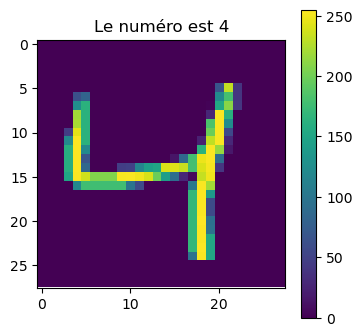

In [26]:
plt.figure(figsize=(4,4))
plt.imshow(X[2])
plt.title(f'Le numéro est {y[2]}')
plt.colorbar()

# Transformation des données 

Dans l'article de recherche, les images sont initialement de taille 16×16, puis redimensionnées en 28×28 afin d'éviter des erreurs ou des problèmes liés aux bordures. Cependant, les images du dataset MNIST sont déjà de taille 28×28. Nous choisissons donc de ne pas les transformer.

Par ailleurs, il est nécessaire de normaliser les images. La normalisation consiste à ramener les valeurs des pixels dans un intervalle restreint, ici entre -1 et 1. Cette étape est essentielle, car des valeurs trop élevées peuvent rendre l’entraînement du modèle instable. Sans normalisation, les mises à jour des poids des neurones seraient trop irrégulières, les grandes valeurs ayant un impact disproportionné sur l'apprentissage par rapport aux plus petites.

Enfin, nous devons appliquer un encodage One-Hot à la variable cible 
y. Cette méthode permet de représenter les labels sous forme de vecteurs binaires. Nous utilisons le One-Hot Encoding car il facilite le calcul de la perte en permettant au modèle de comparer directement les probabilités prédites avec les labels réels.

In [29]:
class NouveauDataset(Dataset):
    def __init__(self, chemin):
        self.X, self.y = torch.load(chemin)
        self.X = (self.X / 255)*2 -1 # car on veut des nombres entre -1 et 1
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ix): 
        return self.X[ix], self.y[ix]

Les fonctions **len** et **getitem** permettent de faciliter la gestion de données.

**Note** : Notre classe "NouveauDataset" hérite de la classe Dataset de PyTorch

**Hériter** signifie que la classe NouveauDataset est une sous-classe de Dataset du module PyTorch. Cela signifie que NouveauDataset reprend toutes les fonctionnalités de Dataset et peut les étendre ou les modifier en redéfinissant certaines méthodes.

## Création des dataset train et test 

In [32]:
train_ds = NouveauDataset('training.pt')
test_ds = NouveauDataset('test.pt')

C:\Users\Nesho\AppData\Local\Temp\ipykernel_62132\1807661869.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.X, self.y = torch.load(chemin)


In [34]:
len(train_ds)

60000

## Dataloader

In [37]:
train_dl = DataLoader(train_ds, batch_size=5)

Nous allons à présent créer un Dataloader. Voici ses principales fonctions et utilités :

**Chargement par lots (Batching)** :

Au lieu de charger toutes les données d'un coup (ce qui pourrait être très coûteux en mémoire), un DataLoader divise les données en batches (lots). Cela permet de traiter les données de manière plus efficace et d'éviter les problèmes de mémoire.

**Shuffling (Mélange des données)** :

Lors de l'entraînement, il est souvent important de mélanger les données pour éviter que le modèle ne surapprenne un ordre particulier de données. Le DataLoader peut mélanger les données à chaque epoch (itération sur l'ensemble des données), ce qui contribue à améliorer la généralisation du modèle.

# Modèle 

In [180]:
class RN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=0) # in_channels = entrée à 1 canal
                                                                                                  # out_channels = 4 feature maps
        # Il faut bien mettre 1 ou 3 dans le in_channels du premier conv2d, et non la taille du batch
        self.avgpool1 = nn.AvgPool2d(kernel_size=2) # mapool2d = pour des images, maxpool1d = pour des textes et/ou audios
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=12, kernel_size=5, stride=1, padding=0)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(12*4*4, 10)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = x.float()
        x = self.tanh(self.conv1(x))
        x = self.avgpool1(x)
        x = self.tanh(self.conv2(x))
        x = self.avgpool2(x)  
        x = self.flatten(x)
        x = x.view(x.shape[0], 12*4*4) # x.shape[0] et ne pas mettre 1, car là on fait pour une image mais après on va faire pour des batch donc
                                       # plusieurs images à la fois => si on le fait pas, problème de dimension  
                                       # les données ont 4 dimensions avant le fc (on ne précise pas le batch mais il est bien présent grâce à unsqueeze)
                                       # mais ici on veut un vecteur donc on doit préciser et mettre x.shape[0] : cela permet de redimensionner 
                                       # automatiquement les données en fonction de la taille du batch, afin de les rendre compatibles avec la couche 
                                       # fully connected
        x = self.dense(x) # pas besoin de préciser x[1] pck le modèle c'est que 5 représente le batch
        return x

L'architecture du modèle, qui est un CNN, suit celle décrite dans le papier de recherche. Il est composé de deux couches de convolution et de deux couches de pooling, utilisant un average pooling. La fonction d'activation n'est pas explicitement précisée dans l'article, mais nous utilisons Tanh plutôt que ReLU, car cette dernière n'était pas encore couramment utilisée dans les années 1990.

- Après conv1 : torch.Size([5, 4, 24, 24])
- Après avgpool1 : torch.Size([5, 4, 12, 12])
- Après conv2 : torch.Size([5, 12, 8, 8])
- Après avgpool2 : torch.Size([5, 12, 4, 4])
- Après flatten : torch.Size([5, 192])
- Après view : torch.Size([x.shape[0], 192])

Dans le réseau de neurones, **in_channels** indique le nombre de canaux (ou "profondeurs") des images d'entrée, pas la taille du batch. Ici, les images ont une taille de 28x28 pixels. Comme le nombre de canaux n'est pas précisé, il est supposé que ce sont des images en noir et blanc, donc il y a seulement 1 canal.

Un problème apparaît lorsqu'une convolution (conv2d) est appliquée. La forme des données d'entrée doit être (batch_size, canaux, hauteur, largeur), c'est-à-dire qu'il faut aussi spécifier le nombre de canaux. Or, ici, la forme est (batch_size, hauteur, largeur), donc il manque la dimension des canaux (qui est 1 dans ce cas).

Pour corriger cela, la fonction **unsqueeze** est utilisée, permettant d'ajouter cette dimension manquante (celle des canaux) aux données d'entrée.

Un autre problème apparaît après l'application de la couche maxpool2d. À ce moment-là, la forme des données devient (5, 12, 4, 4) (cela signifie qu'il y a 5 images dans le batch, avec 12 canaux, et chaque image fait 4x4 pixels après le max-pooling). Cependant, après cette étape, les données doivent être connectées à une couche entièrement connectée (fully connected). Or, cette couche attend des données sous forme de vecteurs, et non de matrices ou de tenseurs 4D.

C'est pourquoi l'ajout de x.shape[0] dans la fonction view est nécessaire. Cela permet de redimensionner automatiquement les données en fonction de la taille du batch, afin de les rendre compatibles avec la couche fully connected.

In [184]:
16*12

192

In [186]:
f = RN()

In [188]:
xs, ys = train_ds[0:5]

In [190]:
ys.shape

torch.Size([5, 10])

In [192]:
xs.shape

torch.Size([5, 28, 28])

In [194]:
xs = xs.unsqueeze(1)

In [196]:
xs.shape

torch.Size([5, 1, 28, 28])

In [198]:
ys 

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)

In [200]:
f(xs)

tensor([[-0.0737,  0.0885,  0.0985,  0.0314, -0.0566,  0.0268, -0.0081, -0.0478,
         -0.0104, -0.0474],
        [-0.0174,  0.0763,  0.0299,  0.0655,  0.0522, -0.0511, -0.0220, -0.0446,
         -0.0091, -0.0905],
        [-0.1260,  0.0112,  0.0964,  0.0140, -0.1033, -0.0514, -0.0861, -0.0043,
         -0.0235, -0.1280],
        [-0.1026,  0.1152,  0.0017,  0.0388, -0.1755, -0.1160, -0.0630, -0.0804,
         -0.0085, -0.0916],
        [-0.1004,  0.0277,  0.0381,  0.0736, -0.0758, -0.0215, -0.0773,  0.0441,
         -0.0926, -0.1353]], grad_fn=<AddmmBackward0>)

In [203]:
# pour pouvoir appliquer f(xs) il faut redimensionner xs (voir pourquoi), mais une fois que le yhat = f(xs) est produit, yhat est de la forme : 
# (nombre d'images * 10)

In [205]:
f(xs).argmax(axis=1)

tensor([2, 1, 2, 1, 3])

# Fonction coût

In [26]:
L = nn.MSELoss() 

La fonction coût utilisée est la MSE (Mean Squared Error). Ce n'est pas la fonction la plus optimale car elle pénalise trop les petites erreurs. La Cross Entropy serait plus adaptée mais c'est la MSE qui est utilisé dans le papier de LeCun donc nous l'utilisons. 

# Optimiseur 

In [ ]:
opt = SGD(f.parameters(), lr=0.01, momentum=0.9)

L'optimiseur n'étant pas précisé dans l'article de recherche, nous utilisons la Descente de Gradient Stochastique. En effet, des optimiseurs plus avancés comme Adam n'étaient pas encore disponibles à l'époque.

# Entraînement du modèle 

Avant de passer à l'entraînement du modèle, clarifions quelques notions de vocabulaire : 

- epoch = une itération complète de notre jeu de données

- batch = le jeu de données est divisé en sous groupes, car traiter toutes les données d'un coup peut être inefficace en mémoire et en calcul.

**Exemple** : Si on a 10 000 images et qu'on utilise un batch size de 100, cela signifie qu’il faudra 100 itérations 
pour compléter 1 epoch.

In [209]:
def training_model(dl, f, n_epochs=20):
    # optimisation 
    opt = SGD(f.parameters(), lr=0.01, momentum=0.9)
    L = nn.MSELoss()
    
    # entraînement 
    loss = []
    epochs = []
    
    for epoch in range(n_epochs): # quand c'est une liste pas besoin de mettre range mais là, c'est un int donc il faut range
        print(f'Epoch : {epoch}')
        N = len(dl)
        
        for i, (x,y) in enumerate(dl): 
        # ici il va faire 12000 itérations car chaque élément contient 5 valeurs 
        # x est l'image et y est le label
            x = x.unsqueeze(1)
            opt.zero_grad() # car sinon les GRADIENTS s'accumulent, toujours le mettre avant le backward
            loss_value = L(f(x.float()), y.float()) # on avait des torch.float64 mais il faut des torch.float32, juste à mettre .float() et c'est réglé
            loss_value.backward() 
            opt.step() # mise à jour des POIDS
            
            epochs.append(epoch+i/N)  # comme ça on a le L (loss) pour chaque batch de chaque epochs
            loss.append(loss_value.item()) # item() parce que c'est un tensor et qu'on veut que la valeur 
    return(np.array(epochs), np.array(loss)) # on convertit en array car sur plt, les listes sont pas adaptées   
                                             # le type quand c'est une liste est list mais pour array c'est float

In [212]:
epoch_data, loss_data = training_model(train_dl, f) # d'où l'utilité du dataloader

Epoch : 0
Epoch : 1
Epoch : 2
Epoch : 3
Epoch : 4
Epoch : 5
Epoch : 6
Epoch : 7
Epoch : 8
Epoch : 9
Epoch : 10
Epoch : 11
Epoch : 12
Epoch : 13
Epoch : 14
Epoch : 15
Epoch : 16
Epoch : 17
Epoch : 18
Epoch : 19


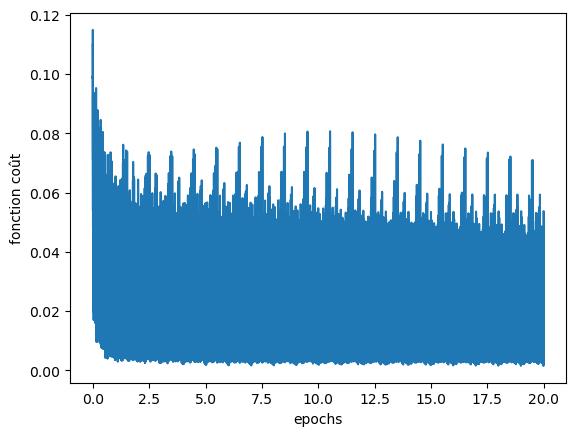

In [214]:
plt.plot(epoch_data, loss_data)
plt.xlabel('epochs')
plt.ylabel('fonction coût')
plt.show()

Dans notre modèle, nous avons calculé le coût (L) pour chaque batch à chaque epoch. Étant donné qu'un batch contient 5 images et qu'il y a 60 000 images au total, chaque epcoh implique le calcul de 12 000 fonctions coût.

Avec 20 epochs, cela représente un total de 240 000 fonctions coût calculées.

Nous observons qu'au fur et à mesure de l'entraînement, les erreurs du modèle diminuent.

In [216]:
loss_data.shape

(240000,)

Nous avons bien 240 000 fonctions de coût calculées. Cependant, ce que nous cherchons à obtenir n'est pas le coût pour chaque batch de chaque epoch, mais le coût moyen par epoch afin de vérifier si les erreurs du modèle diminuent au fil de l'entraînement. Ainsi, pour chaque epoch, nous calculons la moyenne de la fonction coût.

In [218]:
epoch_data_moyenne = epoch_data.reshape(20, -1).mean(axis=1)
loss_data_moyenne = loss_data.reshape(20, -1).mean(axis=1)

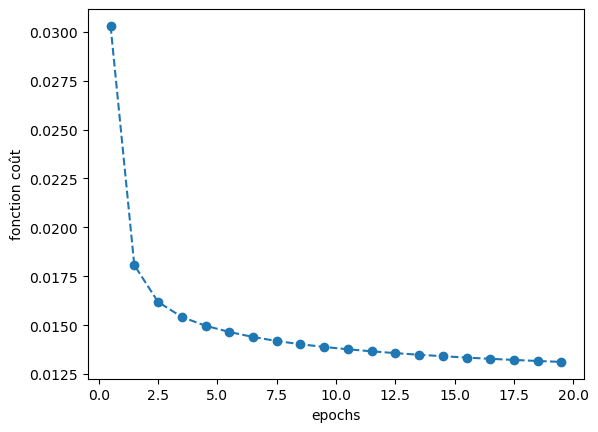

In [220]:
plt.plot(epoch_data_moyenne, loss_data_moyenne, 'o--')
plt.xlabel('epochs')
plt.ylabel('fonction coût')
plt.show()

In [222]:
loss_data_moyenne

array([0.03029942, 0.01806888, 0.01618964, 0.01541963, 0.01497244,
       0.01465222, 0.01439747, 0.01419241, 0.01402591, 0.01388698,
       0.01376793, 0.01366383, 0.01357132, 0.01348807, 0.0134125 ,
       0.01334356, 0.01328045, 0.01322262, 0.01316967, 0.01312125])

Nous constatons qu'au fur et à mesure de l'entraînement, les erreurs du modèle diminuent. Au début, l'erreur était de 0.03 pour atteindre 0.01 à la fin.

# Vérification 

Nous devons à présent déterminer la classe prédite par notre modèle pour chaque image. Pour cela, nous utilisons une couche argmax. La fonction argmax retourne l’index de la plus grande valeur dans le tenseur.

In [225]:
xs2, ys2 = train_ds[0:200]
xs2 = xs2.unsqueeze(1)
yhat = f(xs2).argmax(axis=1)

In [227]:
xs2.shape

torch.Size([200, 1, 28, 28])

In [229]:
f(xs2).shape

torch.Size([200, 10])

In [231]:
len(yhat) # BIG PROBLEME 

200

In [233]:
xs2.shape

torch.Size([200, 1, 28, 28])

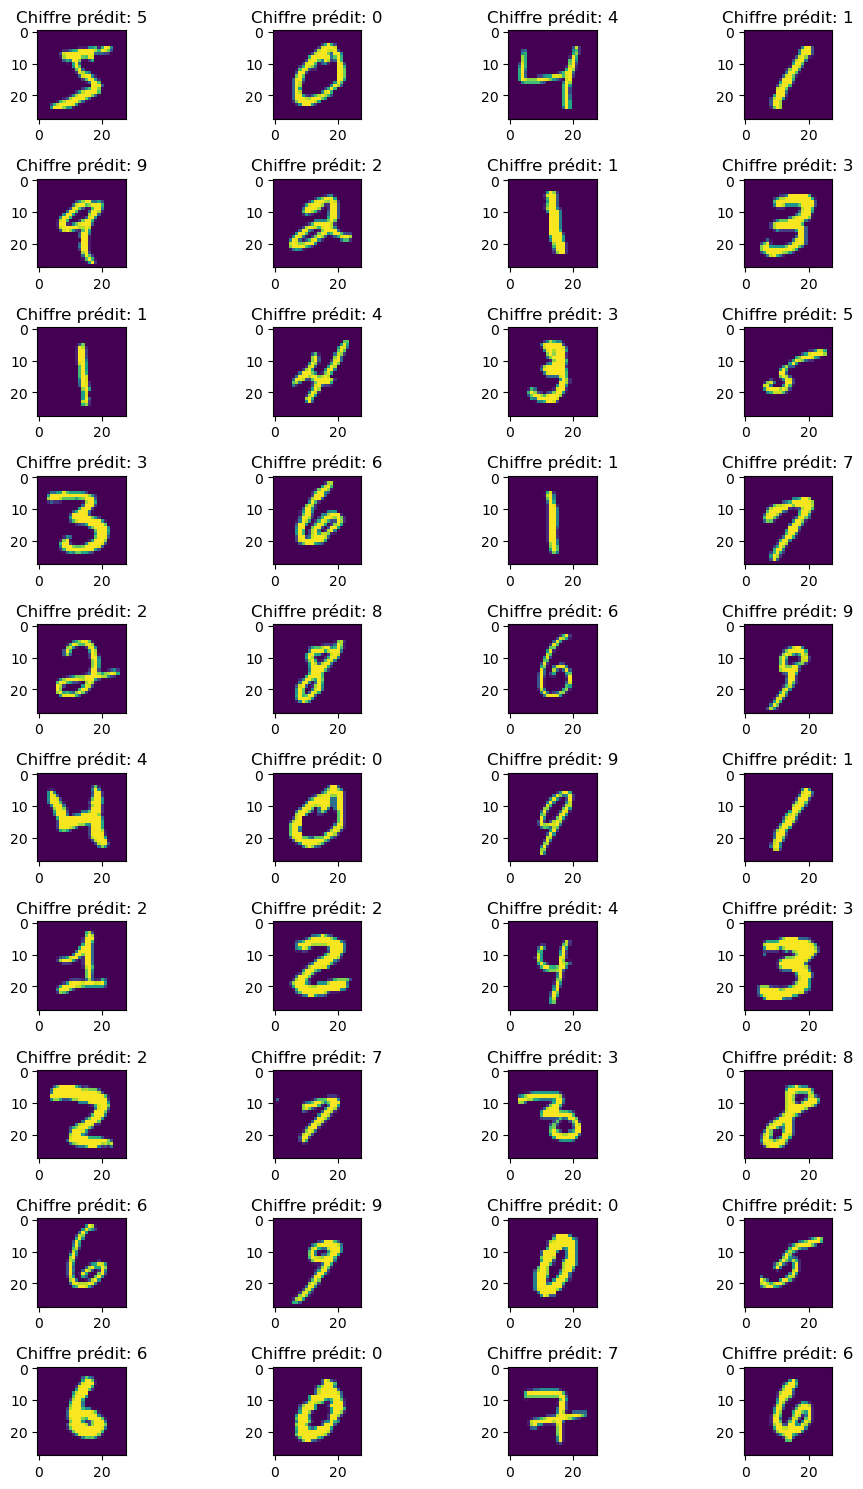

In [235]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs2[i].squeeze())
    plt.title(f'Chiffre prédit: {yhat[i]}')
fig.tight_layout() # pour une meilleure présentation
plt.show()

Le modèle est performant, il arrrive à correctement prédire les chiffres manuscrits.

# Vérification avec le test set

Il faut maintenant vérifier si le modèle souffre de surapprentissage ou de sous-apprentissage des données. C'est là qu'intervient le test set, car le modèle n'a jamais vu ces images.

In [237]:
xt, yt = test_ds[0:2000]
xt = xt.unsqueeze(1)
yt_hat = f(xt).argmax(axis=1)

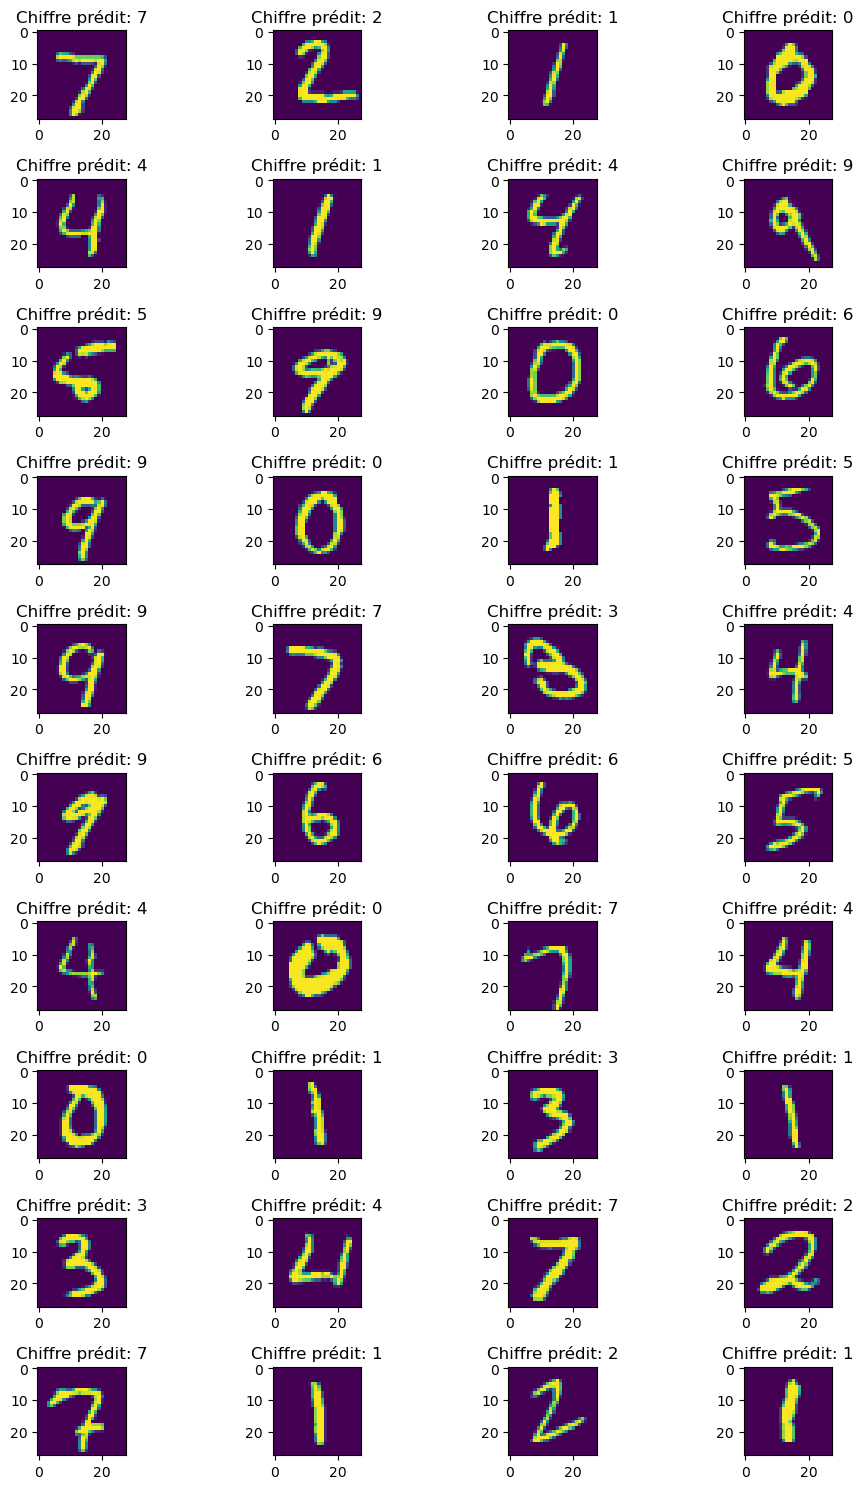

In [239]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xt[i].squeeze(0))
    plt.title(f'Chiffre prédit: {yt_hat[i]}')
fig.tight_layout() # pour une meilleure présentation
plt.show()

Le modèle est très bon car il n'y pas de surapprentissage.

# Conclusion

En conclusion, notre modèle montre de très bonnes performances dans la reconnaissance des chiffres manuscrits. En effet, il est capable de prédire avec précision, sans surapprentissage, comme l'indique l'évaluation sur le test set. Les erreurs du modèle diminuent significativement au fil des epochs, ce qui témoigne de l'efficacité de l'apprentissage. Ainsi, nous pouvons affirmer que le modèle est bien entraîné et qu'il généralise correctement sur de nouvelles données.

Notre objectif, qui était de reproduire l’architecture décrite dans le papier de recherche de Yann LeCun sur la reconnaissance des chiffres manuscrits, confirme la pertinence de cette approche lorsqu'on examine les résultats obtenus et démontre l’efficacité de l’apprentissage par rétropropagation dans un réseau de neurones convolutionnel.